# Question 1

### A)

In [1]:
library(klaR)
library(verification)
library(rpart)

library(glue)
library(caret)
library(dplyr)

Warning message:
"package 'klaR' was built under R version 3.6.2"Loading required package: MASS
Warning message:
"package 'verification' was built under R version 3.6.2"Loading required package: fields
Warning message:
"package 'fields' was built under R version 3.6.2"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.6.2"Loading required package: dotCall64
Warning message:
"package 'dotCall64' was built under R version 3.6.2"Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
Warning message:
"package 'maps' was built under R version 3.6.2"See https://github.com/NCAR/Fiel

In [2]:
# R
nest <- read.csv("../../Data/Nest.csv")

In [3]:
# R
kappa=function(x){
      n=sum(x)
      pobs=(x[1,1]+x[2,2])/n
      pexp=(sum(x[1,])*sum(x[,1])+sum(x[2,])*sum(x[,2]))/n^2
      kappa=(pobs-pexp)/(1-pexp)
      t1=0
      t2=0
      t3=0
      pii=x/n
      pidot=apply(pii,1,sum)
      pdotj=apply(pii,2,sum)
      for(i in 1:2){
            t1 = t1 + pii[i,i]*((1-pexp) - (1-pobs)*(pidot[i]+pdotj[i]))^2
      }
      t2 = pii[1,2]*(pdotj[1]+pidot[2])^2 + pii[2,1]*(pdotj[2] + pidot[1])^2
      t3 = (pobs*pexp-2*pexp+pobs)^2
      vhat = (t1 + t2*(1-pobs)^2 -t3)/(n*(1-pexp)^4)
      se=sqrt(vhat)
      return(c(kappa,se))
}


class.sum=function(truth,predicted){
     xt=table(truth,round(predicted+0.000001))
     pcc=round(100*sum(diag(xt))/sum(xt),2)
     spec=round(100*xt[1,1]/sum(xt[1,]),2)
     sens=round(100*xt[2,2]/sum(xt[2,]),2)
     kap=round(kappa(xt)[1],4)
     au=round(roc.area(truth,predicted)$A,4)
     return(cbind(c("Percent Correctly Classified = ","Specificity = ","Sensitivity = ","Kappa =","AUC= "),c(pcc,spec,sens,kap,au)))
     }

In [4]:
head(nest)

Nest,Species,NumTreelt1in,NumTree1to3in,NumTree3to6in,NumTree6to9in,NumTree9to15in,NumTreegt15in,NumSnags,NumDownSnags,PctShrubCover,NumConifer,StandType
0,Non-nest,27,3,9,20,18,4,1,3,0.0,1,0
0,Non-nest,164,13,14,13,29,3,3,4,0.4,0,1
0,Non-nest,0,10,19,26,11,4,5,4,0.0,0,1
0,Non-nest,139,22,19,7,11,6,3,11,0.1,0,1
0,Non-nest,0,1,48,13,5,0,7,13,0.1,16,0
0,Non-nest,156,59,26,25,9,0,2,3,0.2,0,1


In [5]:
Nest.knn = sknn(as.factor(Nest) ~ . , data = nest, kn = 7)
table(nest$Nest, predict(Nest.knn)$posterior[,2])

   
     0 0.142857142857143 0.285714285714286 0.428571428571429 0.571428571428571
  0 42                21                13                 5                11
  1  0                 2                 4                 5                10
   
    0.714285714285714 0.857142857142857  1
  0                 8                 6  0
  1                 9                59 18

In [6]:
class.sum(nest$Nest, predict(Nest.knn)$posterior[,2])

Percent Correctly Classified =,83.1
Specificity =,76.42
Sensitivity =,89.72
Kappa =,0.6618
AUC=,0.9248


In [7]:
set.seed(12345)
Nest.knn.xval.class=rep(0,nrow(nest))
Nest.knn.xval.posterior=rep(0,nrow(nest))
xvs=rep(1:10,length=nrow(nest))
xvs=sample(xvs)
for(i in 1:10){
    train=nest[xvs!=i,]
    test=nest[xvs==i,]
    glub=sknn(as.factor(Nest) ~ . ,data=train,kn=3)
    Nest.knn.xval.posterior[xvs==i]=predict(glub,test)$posterior[,2]
    Nest.knn.xval.class[xvs==i]=predict(glub,test)$class
}
table(nest$Nest, Nest.knn.xval.class)
class.sum(nest$Nest, Nest.knn.xval.posterior)

   Nest.knn.xval.class
     1  2
  0 80 26
  1 16 91

Percent Correctly Classified =,80.28
Specificity =,75.47
Sensitivity =,85.05
Kappa =,0.6055
AUC=,0.8497


In [8]:
# R
nest.logt <- log(nest[,3:12]+1)
nest.log.df <- cbind(nest[,1:2], nest.logt, StandType = nest[, 13])

In [9]:
# R
set.seed(12345)
Nest.knn.xval.class=rep(0,nrow(nest.log.df))
Nest.knn.xval.posterior=rep(0,nrow(nest.log.df))

In [10]:
# R
set.seed(12345)
Nest.knn.xval.class=rep(0,nrow(nest.log.df))
Nest.knn.xval.posterior=rep(0,nrow(nest.log.df))

xvs=rep(1:10,length=nrow(nest.log.df))
xvs=sample(xvs)
for(i in 1:10){
    train=nest.log.df[xvs!=i,]
    test=nest.log.df[xvs==i,]
    glub=sknn(as.factor(Nest) ~ . ,data=train,kn=5) # How do I decide what value to choose again 6
    Nest.knn.xval.posterior[xvs==i]=predict(glub,test)$posterior[,2]
    Nest.knn.xval.class[xvs==i]=predict(glub,test)$class
}
table(actual = nest.log.df$Nest, predicted = Nest.knn.xval.class)
class.sum(nest.log.df$Nest, Nest.knn.xval.posterior)

      predicted
actual   1   2
     0 100   6
     1  10  97

Percent Correctly Classified =,92.49
Specificity =,94.34
Sensitivity =,90.65
Kappa =,0.8498
AUC=,0.9748


In [11]:
class.sum(nest.log.df$Nest, Nest.knn.xval.posterior)

Percent Correctly Classified =,92.49
Specificity =,94.34
Sensitivity =,90.65
Kappa =,0.8498
AUC=,0.9748


B)

In [12]:
# R
chickadee <- droplevels(subset( nest.log.df, 
                       Species == "Chickadee" | Species == "Non-nest",
                       select = -Species))
flicker <- droplevels(subset( nest.log.df, 
                       Species == "Flicker" | Species == "Non-nest",
                       select = -Species))
sapsucker <- droplevels(subset( nest.log.df, 
                       Species == "Sapsucker" | Species == "Non-nest",
                       select = -Species))

In [13]:
# R Chickadee
dataset = chickadee
set.seed(12345)
Nest.knn.xval.class=rep(0,nrow(dataset))
Nest.knn.xval.posterior=rep(0,nrow(dataset))

xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
    train=dataset[xvs!=i,]
    test=dataset[xvs==i,]
    glub=sknn(as.factor(Nest) ~ . ,data=train,kn=9) # How do I decide what value to choose again
    Nest.knn.xval.posterior[xvs==i]=predict(glub,test)$posterior[,2]
    Nest.knn.xval.class[xvs==i]=predict(glub,test)$class
}
table(actual = dataset$Nest, predicted = Nest.knn.xval.class)
class.sum(dataset$Nest, Nest.knn.xval.posterior)

      predicted
actual  1  2
     0 98  8
     1 16 26

Percent Correctly Classified =,83.78
Specificity =,92.45
Sensitivity =,61.9
Kappa =,0.5767
AUC=,0.8896


In [14]:
# R flicker
dataset = flicker
set.seed(12345)
Nest.knn.xval.class=rep(0,nrow(dataset))
Nest.knn.xval.posterior=rep(0,nrow(dataset))

xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
    train=dataset[xvs!=i,]
    test=dataset[xvs==i,]
    glub=sknn(as.factor(Nest) ~ . ,data=train,kn=4) # How do I decide what value to choose again
    Nest.knn.xval.posterior[xvs==i]=predict(glub,test)$posterior[,2]
    Nest.knn.xval.class[xvs==i]=predict(glub,test)$class
}
table(actual = dataset$Nest, predicted = Nest.knn.xval.class)
class.sum(dataset$Nest, Nest.knn.xval.posterior)

      predicted
actual   1   2
     0 105   1
     1  12  11

Percent Correctly Classified =,89.92
Specificity =,98.11
Sensitivity =,52.17
Kappa =,0.5938
AUC=,0.8997


In [15]:
# R sapsucker
dataset = sapsucker
set.seed(12345)
Nest.knn.xval.class=rep(0,nrow(dataset))
Nest.knn.xval.posterior=rep(0,nrow(dataset))

xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
    train=dataset[xvs!=i,]
    test=dataset[xvs==i,]
    glub=sknn(as.factor(Nest) ~ . ,data=train,kn=2) # How do I decide what value to choose again
    Nest.knn.xval.posterior[xvs==i]=predict(glub,test)$posterior[,2]
    Nest.knn.xval.class[xvs==i]=predict(glub,test)$class
}
table(actual = dataset$Nest, predicted = Nest.knn.xval.class)
class.sum(dataset$Nest, Nest.knn.xval.posterior)

      predicted
actual  1  2
     0 95 11
     1 11 31

Percent Correctly Classified =,86.49
Specificity =,85.85
Sensitivity =,88.1
Kappa =,0.6899
AUC=,0.8911


Possible link that may help in determining what value to use for K. [Link](https://bradleyboehmke.github.io/HOML/knn.html)

# Question 2
## A)

In [16]:
dev=function(y){
	dev=sum((y-mean(y))^2)
      return(dev)
	}

findsplit=function(z){
	zsort=z[order(z[,1]),]
	n=nrow(z)
	w=data.frame(matrix(0,ncol=7,nrow=n-1))
	names(w)=c("Splitpoint","RSSleft","RSSright","RSStotal","MSEleft","MSEright","MSEtotal")
	for(j in 1:n-1){
		w[j,1] = (zsort[j,1] + zsort[j+1,1])/2
		w[j,2] = dev(zsort[1:j,2])
		w[j,5] = w[j,2]/j
		w[j,3] = dev(zsort[(j+1):n,2])
		w[j,6] = w[j,3]/(n-j)
		w[j,4] = w[j,2] + w[j,3]
		w[j,7] = w[j,4]/n
	}
	return(list(zsort,w))
}

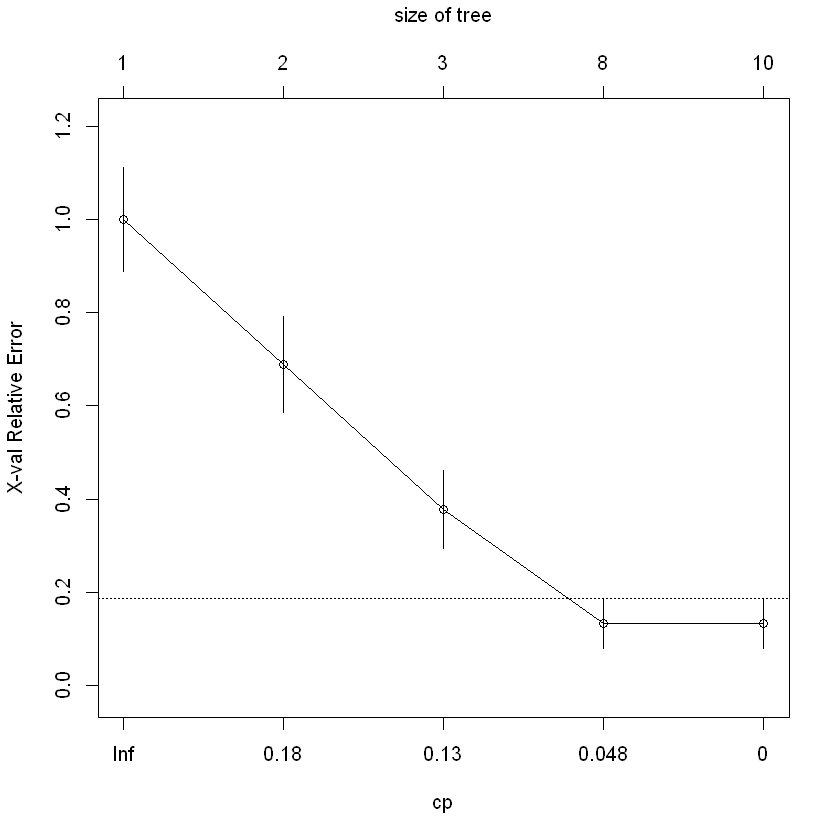

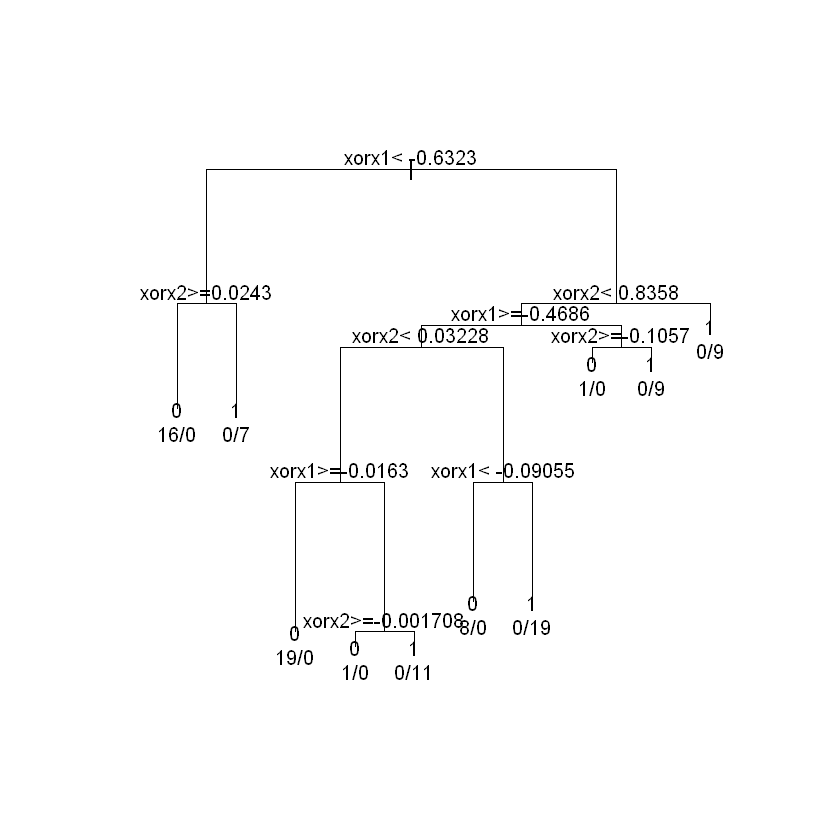

In [17]:
xor=read.csv("../../Data/xor.csv")

xorrpartfull=rpart(xory~xorx1+xorx2,data=xor,method="class",control=rpart.control(cp=0.0,minsplit=2))
plotcp(xorrpartfull)

plot(xorrpartfull,margin=0.1)
text(xorrpartfull,use.n=TRUE)

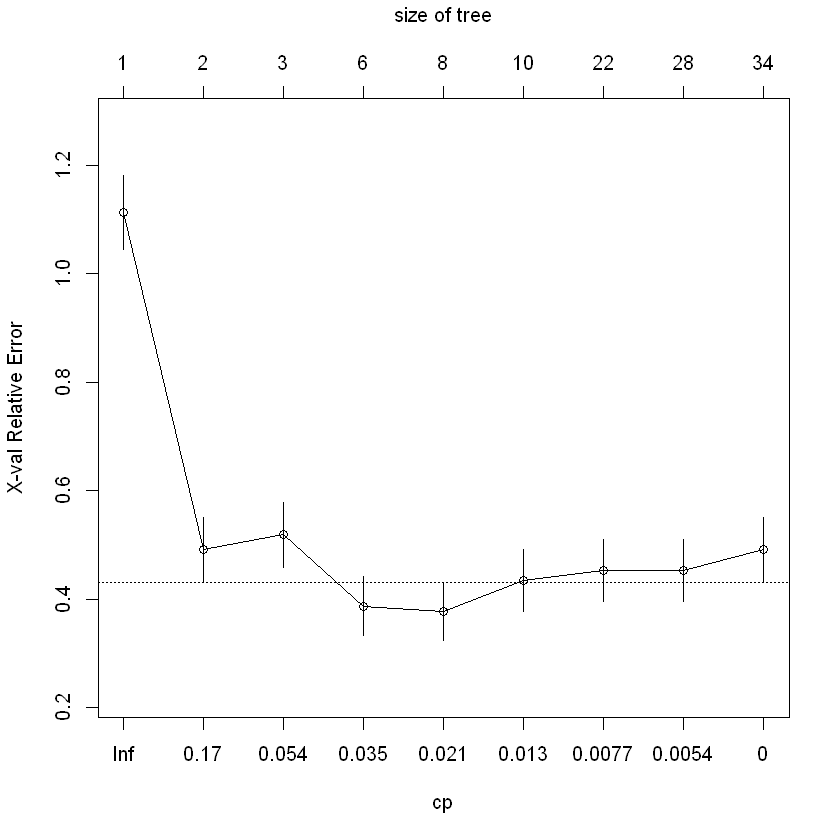

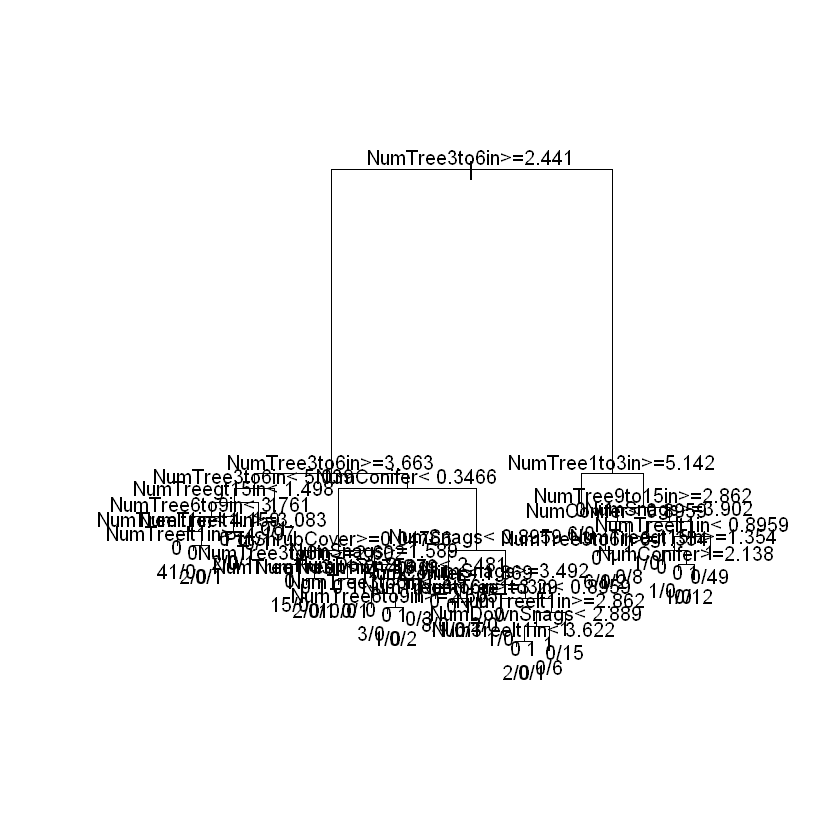

In [18]:
# Reference: https://bradleyboehmke.github.io/HOML/DT.html
dataset = nest.log.df

nestrpartfull=rpart(Nest ~ .-Species, data=dataset,method="class",control=rpart.control(cp=0.0,minsplit=2))
plotcp(nestrpartfull)

plot(nestrpartfull,margin=0.1)
text(nestrpartfull,use.n=TRUE)
# Make sure I understand this correctly. cp should now = .035

   
     0  1
  0 91 15
  1 14 93

Percent Correctly Classified =,86.38
Specificity =,85.85
Sensitivity =,86.92
Kappa =,0.7277
AUC=,0.8876


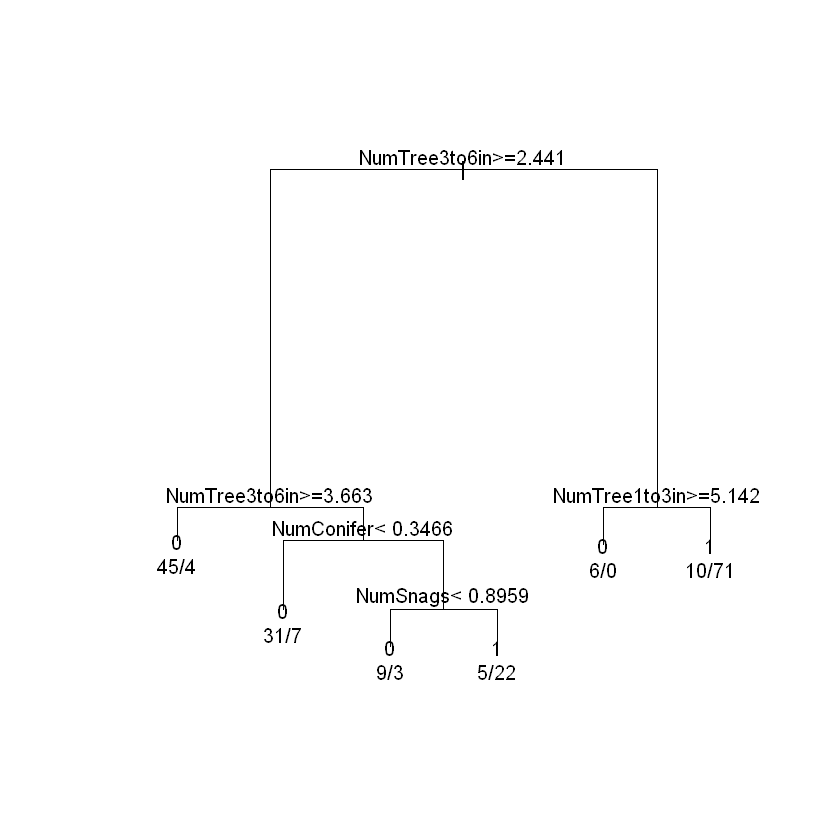

In [19]:
nestcp048=rpart(Nest ~ .-Species,data=dataset,method="class",control=rpart.control(cp=0.035,minsplit=2))

plot(nestcp048,margin=0.1)
text(nestcp048,use.n=TRUE)

table(dataset$Nest, predict(nestcp048,type="class"))
class.sum(dataset$Nest,predict(nestcp048,type="prob")[,2])

In [20]:
set.seed(6066)
nest.xval.predprob=rep(0,length=nrow(dataset))
nest.xval.predclass=rep(0,length=nrow(dataset))
xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
     train = dataset[xvs!=i,]
     test = dataset[xvs==i,]
     glub=rpart(Nest ~ .-Species,data=train,method="class",control=rpart.control(cp=0.035,minsplit=2))
     nest.xval.predprob[xvs==i]=predict(glub,test,type="prob")[,2]
     nest.xval.predclass[xvs==i]=predict(glub,test,type="class")
   }

table(dataset$Nest,nest.xval.predclass)
class.sum(dataset$Nest,nest.xval.predprob)

   nest.xval.predclass
     1  2
  0 89 17
  1 25 82

Percent Correctly Classified =,80.28
Specificity =,83.96
Sensitivity =,76.64
Kappa =,0.6058
AUC=,0.8115


In [21]:
nest.xval.predprob=rep(0,length=nrow(dataset))
nest.xval.predclass=rep(0,length=nrow(dataset))
xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
     train = dataset[xvs!=i,]
     test = dataset[xvs==i,]
     glub=rpart(Nest ~ .-Species,data=train,method="class",control=rpart.control(cp=0.0,minsplit=2))
     nest.xval.predprob[xvs==i]=predict(glub,test,type="prob")[,2]
     nest.xval.predclass[xvs==i]=predict(glub,test,type="class")
   }

table(dataset$Nest,nest.xval.predclass)
class.sum(dataset$Nest,nest.xval.predprob)

   nest.xval.predclass
     1  2
  0 79 27
  1 19 88

Percent Correctly Classified =,78.4
Specificity =,74.53
Sensitivity =,82.24
Kappa =,0.5679
AUC=,0.7865


## B)

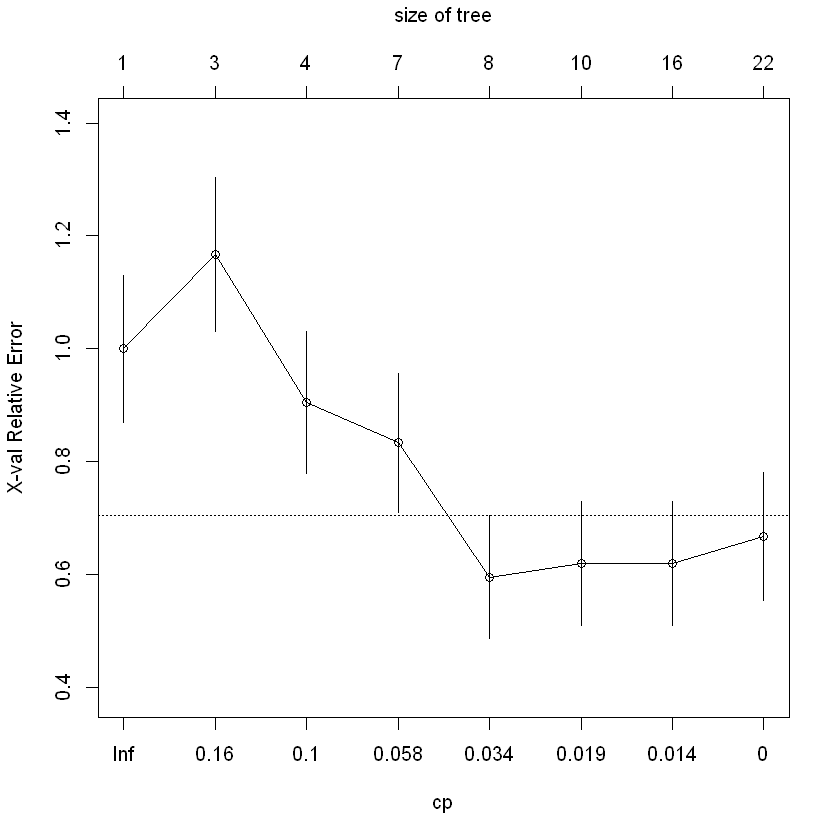

In [22]:
dataset = chickadee

nestrpartfull=rpart(Nest ~ ., 
                    data=dataset,
                    method="class",
                    control=rpart.control(cp=0.0,minsplit=2))
plotcp(nestrpartfull)

## C)

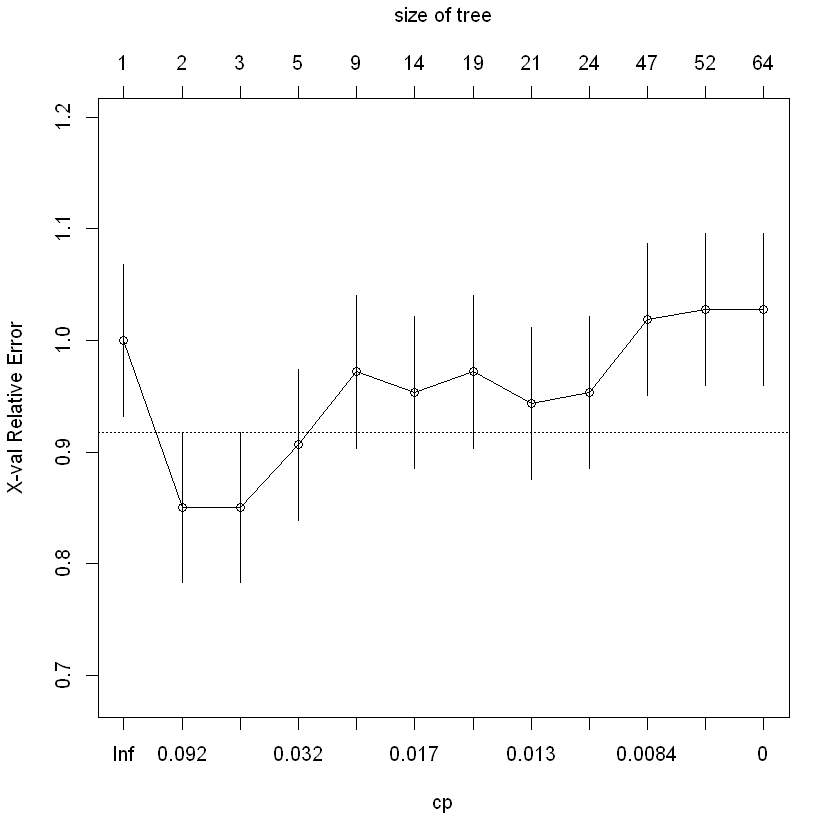

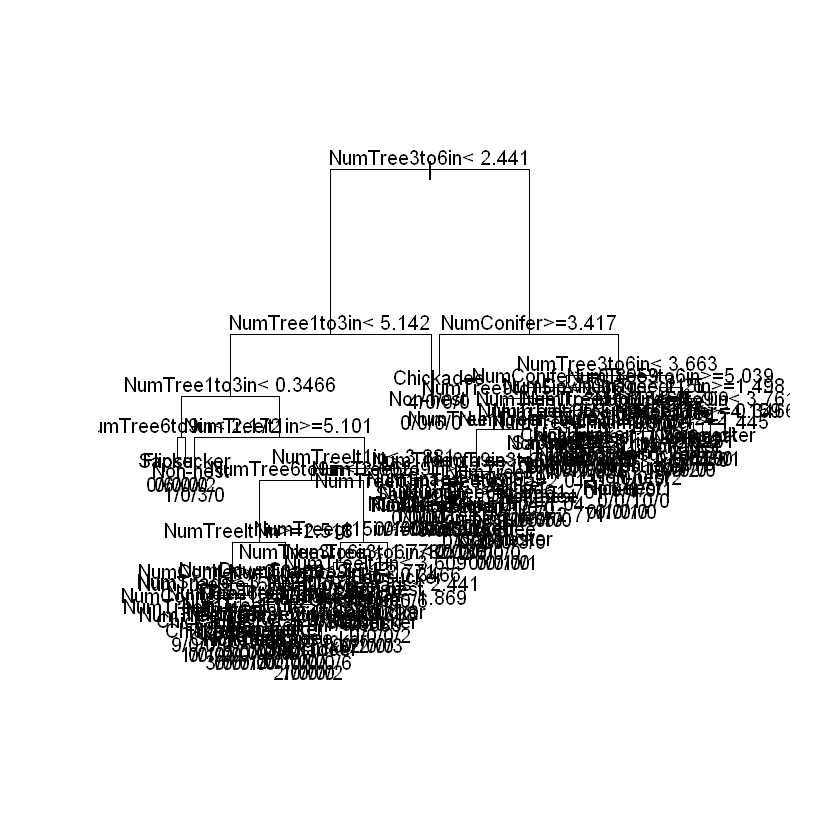

In [23]:
dataset = nest.log.df

nestrpartfull=rpart(Species ~ . - Nest, 
                    data=dataset,
                    method="class",
                    control=rpart.control(cp=0.0,minsplit=2))
plotcp(nestrpartfull)

plot(nestrpartfull,margin=0.1)
text(nestrpartfull,use.n=TRUE)

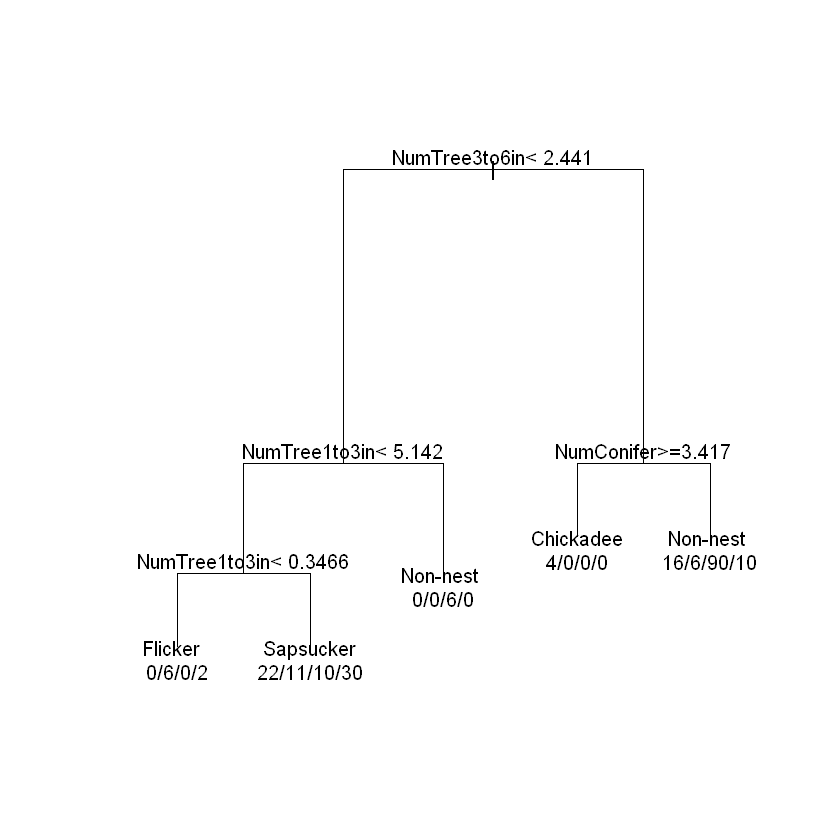

In [24]:
nestrpartfull=rpart(Species ~ . - Nest, 
                    data=dataset,
                    method="class",
                    control=rpart.control(cp=0.032,minsplit=2))
plot(nestrpartfull,margin=0.1)
text(nestrpartfull,use.n=TRUE)

In [25]:
head(dataset)

Nest,Species,NumTreelt1in,NumTree1to3in,NumTree3to6in,NumTree6to9in,NumTree9to15in,NumTreegt15in,NumSnags,NumDownSnags,PctShrubCover,NumConifer,StandType
0,Non-nest,3.332205,1.3862944,2.302585,3.044522,2.944439,1.609438,0.6931472,1.386294,0.00000000,0.6931472,0
0,Non-nest,5.105945,2.6390573,2.708050,2.639057,3.401197,1.386294,1.3862944,1.609438,0.33647224,0.0000000,1
0,Non-nest,0.000000,2.3978953,2.995732,3.295837,2.484907,1.609438,1.7917595,1.609438,0.00000000,0.0000000,1
0,Non-nest,4.941642,3.1354942,2.995732,2.079442,2.484907,1.945910,1.3862944,2.484907,0.09531018,0.0000000,1
0,Non-nest,0.000000,0.6931472,3.891820,2.639057,1.791759,0.000000,2.0794415,2.639057,0.09531018,2.8332133,0
0,Non-nest,5.056246,4.0943446,3.295837,3.258097,2.302585,0.000000,1.0986123,1.386294,0.18232156,0.0000000,1


           
            Chickadee Flicker Non-nest Sapsucker
  Chickadee         4       0       16        22
  Flicker           0       6        6        11
  Non-nest          0       0       96        10
  Sapsucker         0       2       10        30

           actual
predicted   Chickadee Flicker Non-nest Sapsucker
  Chickadee         0       3        2        10
  Flicker           3       5        1         3
  Non-nest         20       6       94        12
  Sapsucker        19       9        9        17

Confusion Matrix and Statistics

           actual
predicted   Chickadee Flicker Non-nest Sapsucker
  Chickadee         0       3        2        10
  Flicker           3       5        1         3
  Non-nest         20       6       94        12
  Sapsucker        19       9        9        17

Overall Statistics
                                          
               Accuracy : 0.5446          
                 95% CI : (0.4752, 0.6128)
    No Information Rate : 0.4977          
    P-Value [Acc > NIR] : 0.0964325       
                                          
                  Kappa : 0.2674          
                                          
 Mcnemar's Test P-Value : 0.0004188       

Statistics by Class:

                     Class: Chickadee Class: Flicker Class: Non-nest
Sensitivity                   0.00000        0.21739          0.8868
Specificity                   0.91228        0.96316          0.6449
Pos Pred Value                0.00000        0.41667          0.712

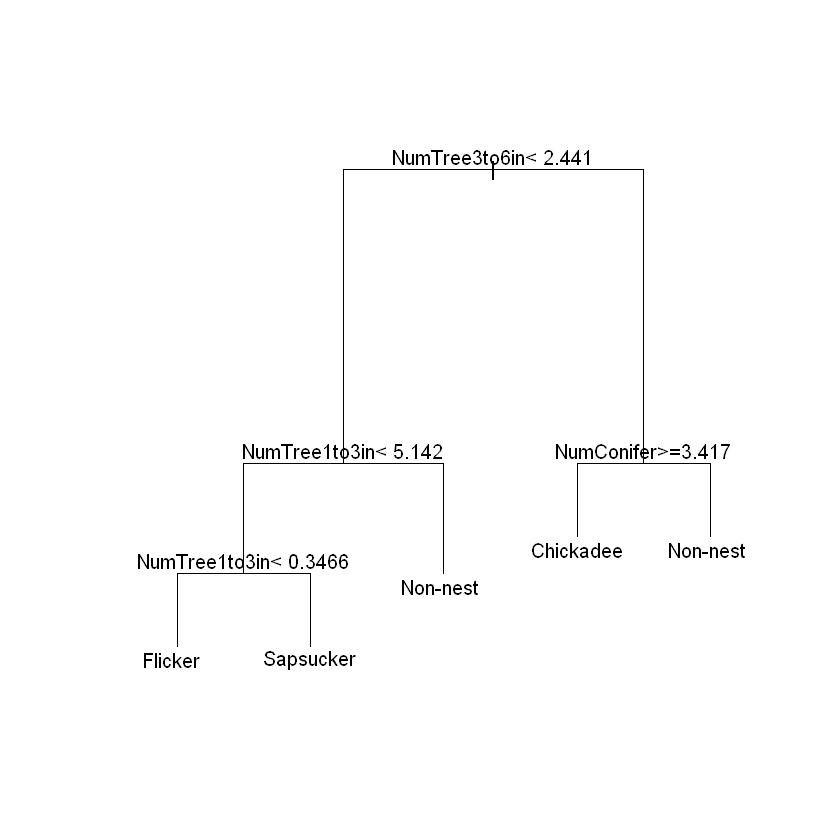

In [26]:
dataset = nest.log.df

snra.cp014=rpart(Species ~ . -Nest ,control=rpart.control(cp=0.032, minsplit=2),data=dataset)
plot(snra.cp014,margin=0.1)
text(snra.cp014)


snra.cp014confuse=table(dataset$Species,predict(snra.cp014,type="class"))
snra.cp014confuse

set.seed(6066)

snra.cp014.xval=rep(0,nrow(dataset))
xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
    test=dataset[xvs==i,]
    train=dataset[xvs!=i,]
    glub=rpart(Species ~ . - Nest,control=rpart.control(cp=0.032, minsplit=2),data=train)
    snra.cp014.xval[xvs==i]=predict(glub,test,type="class")
    as.data.frame(snra.cp014.xval)
    snra.cp014.xval[snra.cp014.xval == 4] = "Sapsucker"
    snra.cp014.xval[snra.cp014.xval == 3] = "Non-nest"
    snra.cp014.xval[snra.cp014.xval == 2] = "Flicker"
    snra.cp014.xval[snra.cp014.xval == 1] = "Chickadee"
}

snra.cp014confuse.xval=table(predicted = snra.cp014.xval, actual = dataset$Species)
snra.cp014confuse.xval
confusionMatrix(snra.cp014confuse.xval)



# set.seed(6066)
# nest.xval.predprob=rep(0,length=nrow(dataset))
# nest.xval.predclass=rep(0,length=nrow(dataset))
# xvs=rep(1:10,length=nrow(dataset))
# xvs=sample(xvs)
# for(i in 1:10){
#      train = dataset[xvs!=i,]
#      test = dataset[xvs==i,]
#      glub=rpart(Species ~ .-Nest,data=train,method="class",control=rpart.control(cp=0.046,minsplit=2))
#      nest.xval.predprob[xvs==i]=predict(glub,test,type="prob")[,2]
#      nest.xval.predclass[xvs==i]=predict(glub,test,type="class")
#    }

# table(actual = dataset$Species, predicted = nest.xval.predclass)
# print(nest.xval.predclass)
# confusionMatrix(table( predicted = nest.xval.predclass, actual = dataset$Species))
# class.sum(dataset$Species,nest.xval.predprob)

# Look at the R code for classification trees for snra. Saw tooth data.
# Use this for the glass as well.
# Library (rpart.plot) For plotting rpart. You can just plot the model. <model_name>$finalModel

In [27]:
# snra.cp014.xval=rep(0,nrow(dataset))
# predict(glub,test,type="class")
as.data.frame(snra.cp014.xval)
snra.cp014.xval[snra.cp014.xval == 4] = "Sapsucker"
snra.cp014.xval[snra.cp014.xval == 3] = "Non-nest"
snra.cp014.xval[snra.cp014.xval == 2] = "Flicker"
snra.cp014.xval[snra.cp014.xval == 1] = "Chickadee"

snra.cp014.xval
Sapsucker
Non-nest
Non-nest
Non-nest
Non-nest
Non-nest
Non-nest
Non-nest
Non-nest
Non-nest


# Question 3
## A)

In [28]:
glass <- read.csv("../../Data/Glass.csv")

In [ ]:
head(glass)

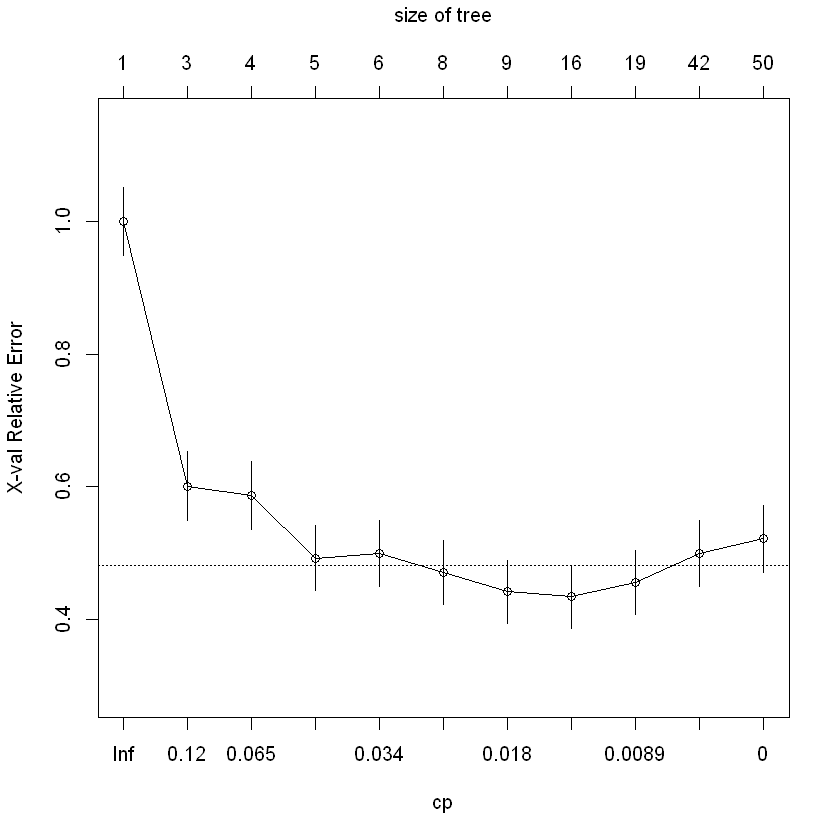

In [44]:
set.seed(5948)
dataset = glass

glassrpartfull=rpart(GlassType ~ ., 
                    data=dataset,
                    method="class",
                    control=rpart.control(cp=0.0,minsplit=2))
plotcp(glassrpartfull)

# plot(glassrpartfull,margin=0.1)
# text(glassrpartfull,use.n=TRUE)

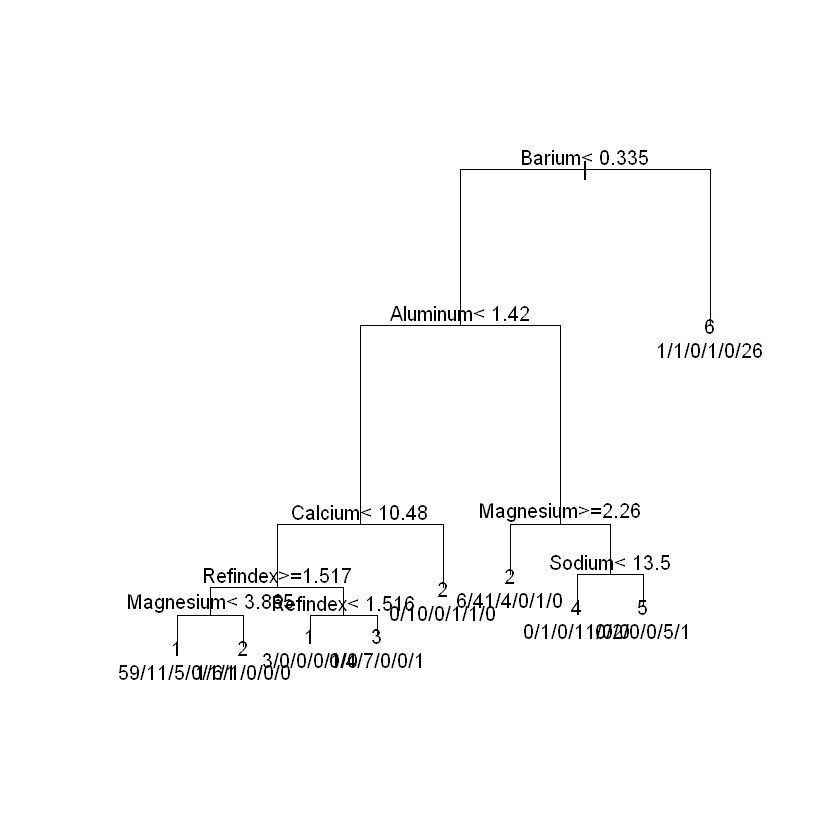

In [31]:
glassrpartfull=rpart(GlassType ~ ., 
                    data=dataset,
                    method="class",
                    control=rpart.control(cp=0.018,minsplit=2))

plot(glassrpartfull,margin=0.1)
text(glassrpartfull,use.n=TRUE)

Write up the answer for this question. Check to see what the 1-se rule is.

## B

In [32]:
data = glass %>%
    filter(GlassType %in% c(1, 2, 3, 4, 6))
head(data)

Refindex,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,GlassType
1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


In [33]:
# dataset = glass %>%
#     filter(GlassType %in% c(1, 2, )) # Left out 3, 4, 5, 6
# dataset[dataset$Glasstype == 5] = 4

set.seed(5688)

snra.cp014.xval=rep(0,nrow(dataset))
xvs=rep(1:10,length=nrow(dataset))
xvs=sample(xvs)
for(i in 1:10){
    test=dataset[xvs==i,]
    train=dataset[xvs!=i,]
    glub=rpart(as.factor(GlassType) ~ .,control=rpart.control(cp=0.018, minsplit=2),data=train)
    snra.cp014.xval[xvs==i]=predict(glub,test,type="class")
}

snra.cp014confuse.xval=table(predicted = snra.cp014.xval, actual = dataset$GlassType)
confusionMatrix(snra.cp014confuse.xval)

Confusion Matrix and Statistics

         actual
predicted  1  2  3  4  5  6
        1 51 16  8  0  2  1
        2 16 53  6  3  4  2
        3  2  2  3  0  0  0
        4  0  2  0  8  0  0
        5  0  2  0  1  3  0
        6  1  1  0  1  0 26

Overall Statistics
                                          
               Accuracy : 0.6729          
                 95% CI : (0.6056, 0.7353)
    No Information Rate : 0.3551          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5434          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.7286   0.6974  0.17647  0.61538  0.33333   0.8966
Specificity            0.8125   0.7754  0.97970  0.99005  0.98537   0.9838
Pos Pred Value         0.6538   0.6310  0.42857  0.80000  0.50000   0.8966
Neg Pred Value         0.

In [ ]:
dataset %>% 
  group_by(GlassType) %>%
  summarise(no_rows = length(GlassType))

In [ ]:
library(dplyr)
glass %>% 
  group_by(GlassType) %>%
  summarise(no_rows = length(GlassType))

In [36]:
glass=read.csv("../../Data/Glass.csv")

names(glass)

[1] "Refindex"  "Sodium"    "Magnesium" "Aluminum"  "Silicon"   "Potassium"
 [7] "Calcium"   "Barium"    "Iron"      "GlassType"

In [37]:
dim(glass)

[1] 214  10

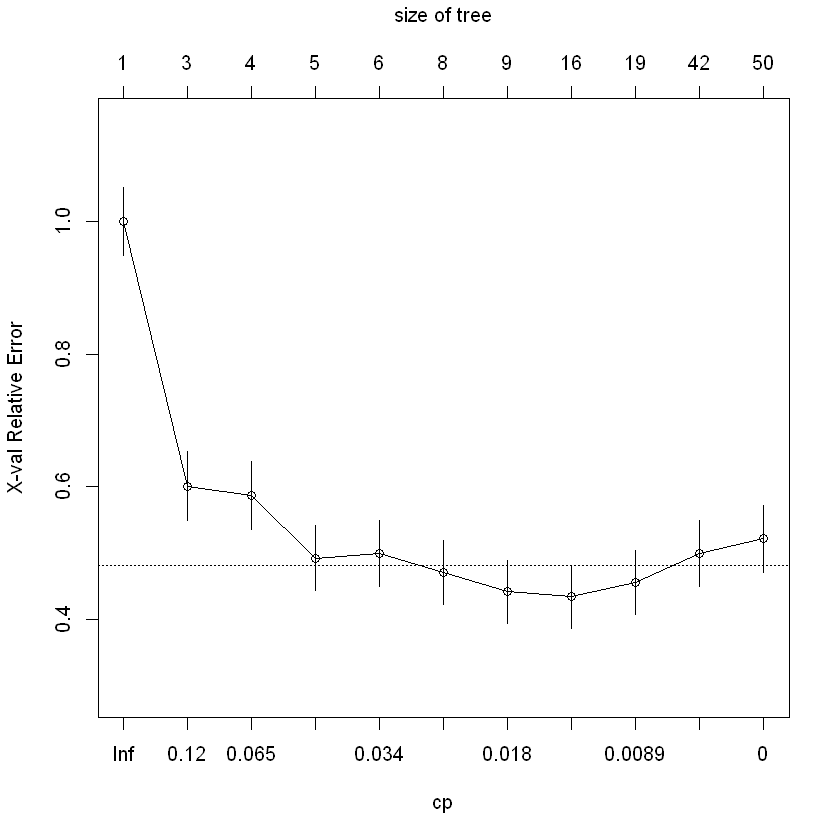

   
     1  2  3  4  5  6
  1 59  7  3  0  0  1
  2 11 57  4  1  2  1
  3  5  5  7  0  0  0
  4  0  1  0 11  0  1
  5  1  2  1  0  5  0
  6  1  0  1  0  1 26

[1] 77.1028

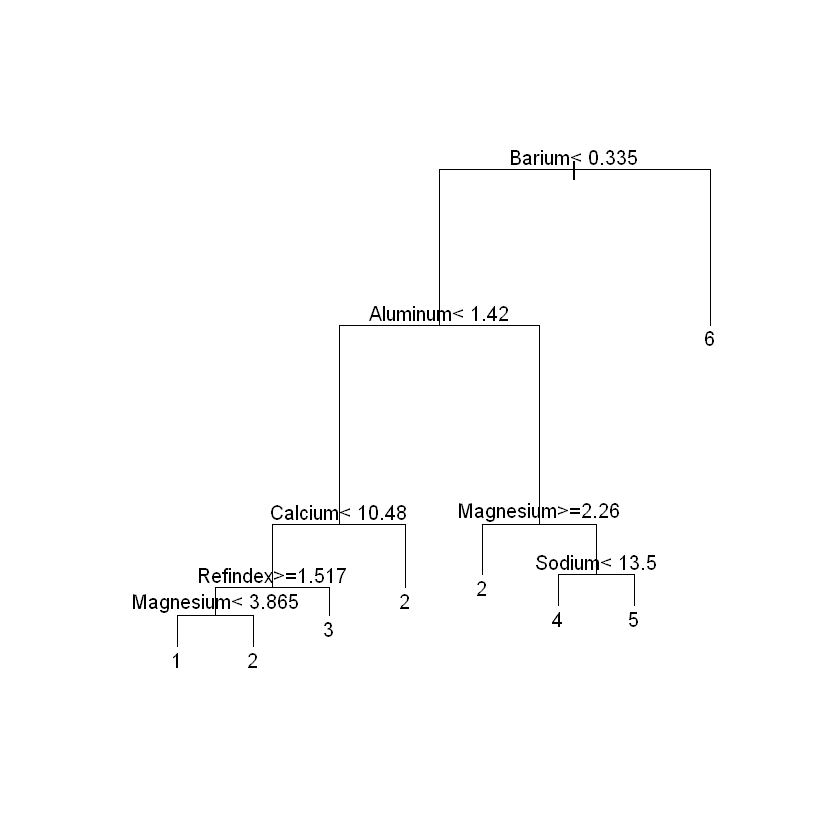

In [38]:
set.seed(5948)

library(rpart)

glass.fulltree=rpart(GlassType ~ . , data=glass, method="class",control=rpart.control(cp=0.0,minsplit=2))
plotcp(glass.fulltree)

glass.cp027=rpart(GlassType ~ . , data=glass, method="class",control=rpart.control(cp=0.027,minsplit=2))
plot(glass.cp027,margin=0.1)
text(glass.cp027)

glass.cp027confuse=table(glass$GlassType,predict(glass.cp027,type="class"))
glass.cp027confuse
100*sum(diag(glass.cp027confuse))/nrow(glass)

   
     1  2  3  4  5  6
  1 62  7  0  0  0  1
  2 11 57  4  1  2  1
  3  5  5  7  0  0  0
  4  0  1  0 11  0  1
  5  2  2  0  0  5  0
  6  1  0  1  0  1 26

[1] 78.50467

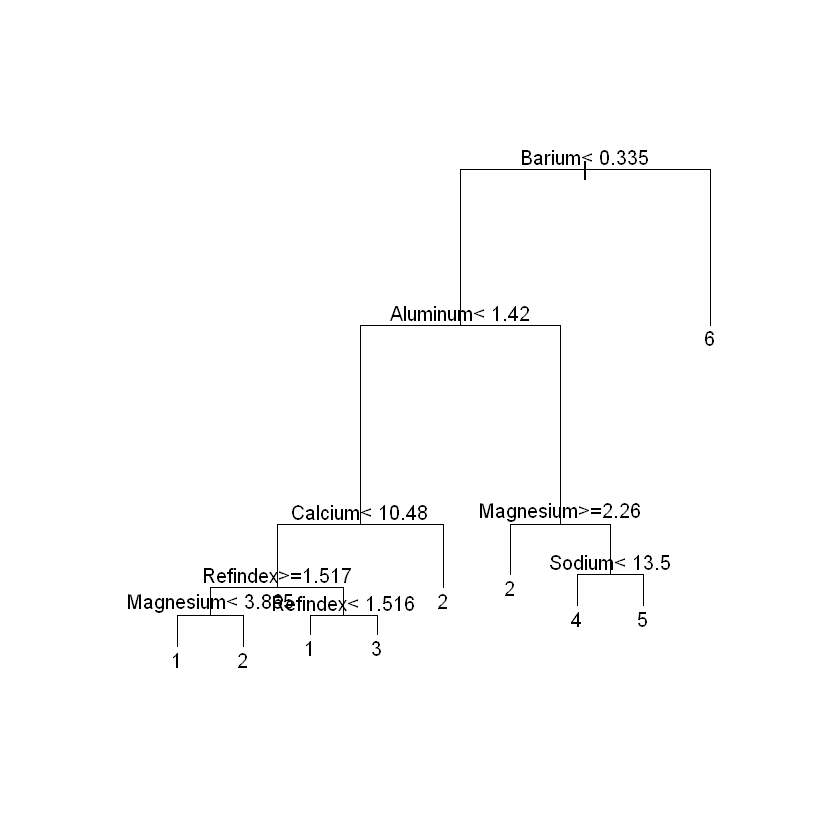

In [39]:
glass.cp018=rpart(GlassType ~ . , data=glass, method="class",control=rpart.control(cp=0.018,minsplit=2))
plot(glass.cp018,margin=0.1)
text(glass.cp018)

glass.cp018confuse=table(glass$GlassType,predict(glass.cp018,type="class"))
glass.cp018confuse
100*sum(diag(glass.cp018confuse))/nrow(glass)

In [40]:
glass.cp027.xval=rep(0,nrow(glass))
xvs=rep(1:10,length=nrow(glass))
xvs=sample(xvs)
for(i in 1:10){
    test=glass[xvs==i,]
    train=glass[xvs!=i,]
    glub=rpart(GlassType ~ . , method="class",control=rpart.control(cp=0.027, minsplit=2),data=train)
    glass.cp027.xval[xvs==i]=predict(glub,test,type="class")
}

glass.cp027confuse.xval=table(glass$GlassType,glass.cp027.xval)
glass.cp027confuse.xval
100*sum(diag(glass.cp027confuse.xval))/nrow(glass)

   glass.cp027.xval
     1  2  3  4  5  6
  1 56 11  2  0  0  1
  2 18 51  2  4  0  1
  3 10  4  3  0  0  0
  4  0  0  0 11  1  1
  5  1  4  1  2  1  0
  6  2  1  0  0  0 26

[1] 69.15888